<a href="https://colab.research.google.com/github/Mageed-Ghaleb/OptimizationSystems-Course/blob/main/OR_Tools_Min_Cost_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Install required packages (run this cell first) ===
!pip install -q "protobuf<6" pyomo ortools highspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
from ortools.graph.python import min_cost_flow

def solve_mcf():
    arcs = [
        (0, 1, 15, 4),
        (0, 2,  8, 4),
        (1, 2, 20, 2),
        (1, 3,  4, 2),
        (1, 4, 10, 6),
        (2, 3, 15, 1),
        (2, 4,  4, 3),
        (3, 4, 20, 2),
    ]
    supplies = {0: 20, 4: -20, 1: 0, 2: 0, 3: 0}

    mcf = min_cost_flow.SimpleMinCostFlow()
    for tail, head, cap, cost in arcs:
        mcf.add_arc_with_capacity_and_unit_cost(tail, head, cap, cost)

    for node, b in supplies.items():
        mcf.set_node_supply(node, b)

    status = mcf.solve()
    if status != mcf.OPTIMAL:
        raise RuntimeError(f"solve failed: {status}")

    print("Optimal cost:", mcf.optimal_cost())
    for a in range(mcf.num_arcs()):
        f = mcf.flow(a)
        if f > 0:
            print(mcf.tail(a), "->", mcf.head(a), "flow", f,
                  "unit cost", mcf.unit_cost(a))

if __name__ == "__main__":
    solve_mcf()


Optimal cost: 160
0 -> 1 flow 12 unit cost 4
0 -> 2 flow 8 unit cost 4
1 -> 2 flow 8 unit cost 2
1 -> 3 flow 4 unit cost 2
2 -> 3 flow 12 unit cost 1
2 -> 4 flow 4 unit cost 3
3 -> 4 flow 16 unit cost 2


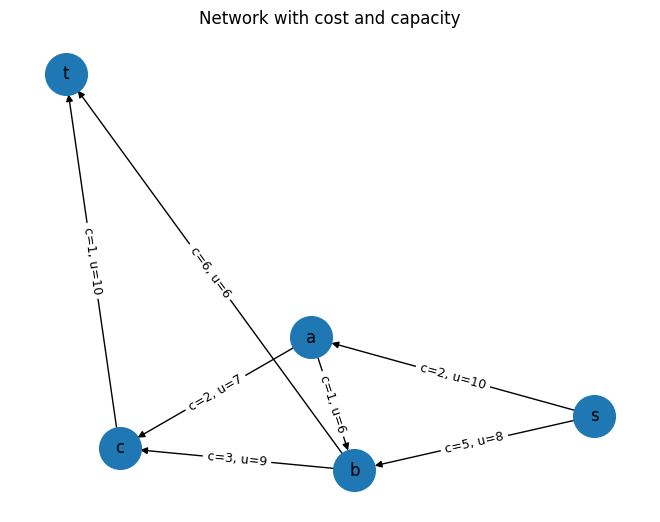

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_cost_capacity_graph(arcs):
    # arcs = (u, v, cost, cap)
    G = nx.DiGraph()
    for u, v, cost, cap in arcs:
        G.add_edge(u, v, cost=cost, cap=cap)

    pos = nx.spring_layout(G, seed=7)
    nx.draw(G, pos, with_labels=True, node_size=900, arrows=True)

    edge_labels = {(u, v): f"c={G[u][v]['cost']}, u={G[u][v]['cap']}"
    for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Network with cost and capacity")
    plt.show()

if __name__ == "__main__":
    arcs = [
        ("s","a",2,10),
        ("s","b",5,8),
        ("a","b",1,6),
        ("a","c",2,7),
        ("b","c",3,9),
        ("c","t",1,10),
        ("b","t",6,6),
    ]
    draw_cost_capacity_graph(arcs)

In [ ]:
import matplotlib.pyplot as plt

def plot_sensitivity(cap_values, obj_values):
    plt.figure()
    plt.plot(cap_values, obj_values, marker="o")
    plt.xlabel("Capacity on selected arc")
    plt.ylabel("Optimal objective value")
    plt.title("Sensitivity: objective vs capacity")
    plt.show()

# fill cap_values/obj_values from repeated solves

### Example 1:

In [ ]:
from ortools.linear_solver import pywraplp

# Nodes
nodes = ["W", "C", "H", "D"]  # Warehouse, Cross-dock, Hub, Hospital

# Supplies (+) / Demands (-)
b = {"W": 5, "C": 0, "H": 0, "D": -5}

# Arcs: (i, j, cost, capacity)
arcs = [
    ("W", "C", 2, 5),
    ("W", "H", 4, 5),
    ("C", "D", 2, 5),
    ("H", "D", 1, 5),
    ("C", "H", 0, 5),
]

In [ ]:
solver = pywraplp.Solver.CreateSolver("GLOP")  # continuous LP

# Decision variables x_ij
x = {}
for i, j, c, u in arcs:
    x[(i, j)] = solver.NumVar(0.0, u, f"x[{i},{j}]")

# Flow balance constraints: sum_out - sum_in = b_i
balance = {}
for i in nodes:
    expr = 0.0
    for (a, b2, c, u) in arcs:
        if a == i:
            expr += x[(a, b2)]
        if b2 == i:
            expr -= x[(a, b2)]
    balance[i] = solver.Add(expr == b[i], f"balance[{i}]")

# Objective: min total cost
obj = solver.Objective()
for i, j, c, u in arcs:
    obj.SetCoefficient(x[(i, j)], c)
obj.SetMinimization()

status = solver.Solve()
print("Status:", status)
print("Optimal cost:", obj.Value())

print("\nFlows:")
for (i, j), var in x.items():
    if var.solution_value() > 1e-9:
        print(f"  {i}->{j}: {var.solution_value():.6g}")

# Shadow prices (dual values) on node balances
print("\nShadow prices (duals) on node balances:")
pi = {}
for i in nodes:
    pi[i] = balance[i].dual_value()
    print(f"  pi[{i}] = {pi[i]:.6g}")

# Reduced costs on arcs
print("\nReduced costs on arcs:")
rc = {}
for (i, j), var in x.items():
    rc[(i, j)] = var.reduced_cost()
    print(f"  rc[{i}->{j}] = {rc[(i, j)]:.6g}")

Status: 0
Optimal cost: 15.0

Flows:
  W->C: 5
  H->D: 5
  C->H: 5

Shadow prices (duals) on node balances:
  pi[W] = 3
  pi[C] = 1
  pi[H] = 0
  pi[D] = -1

Reduced costs on arcs:
  rc[W->C] = 0
  rc[W->H] = 1
  rc[C->D] = 0
  rc[H->D] = 0
  rc[C->H] = -1


In [ ]:
def solve_with_rhs(b_override):
    solver2 = pywraplp.Solver.CreateSolver("GLOP")
    x2 = {}
    for i, j, c, u in arcs:
        x2[(i, j)] = solver2.NumVar(0.0, u, f"x[{i},{j}]")

    balance2 = {}
    for i in nodes:
        expr = 0.0
        for (a, b2, c, u) in arcs:
            if a == i:
                expr += x2[(a, b2)]
            if b2 == i:
                expr -= x2[(a, b2)]
        balance2[i] = solver2.Add(expr == b_override[i], f"balance[{i}]")

    obj2 = solver2.Objective()
    for i, j, c, u in arcs:
        obj2.SetCoefficient(x2[(i, j)], c)
    obj2.SetMinimization()

    st = solver2.Solve()
    return obj2.Value(), {i: balance2[i].dual_value() for i in nodes}

base_cost, base_pi = solve_with_rhs(b)

b2 = dict(b)
b2["W"] += 1
b2["D"] -= 1

new_cost, _ = solve_with_rhs(b2)

pred_delta = base_pi["W"]*(+1) + base_pi["D"]*(-1)
actual_delta = new_cost - base_cost

print("Base cost:", base_cost)
print("New cost :", new_cost)
print("Predicted Δcost from duals:", pred_delta)
print("Actual Δcost:", actual_delta)

Base cost: 15.0
New cost : 21.0
Predicted Δcost from duals: 4.0
Actual Δcost: 6.0
